In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from sqlalchemy import create_engine

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
from scipy.sparse import csr_matrix

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
from sklearn.preprocessing import MaxAbsScaler

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
from matplotlib.legend_handler import HandlerLine2D

In [6]:
import datetime as dt

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter('ignore')

# Data Pre-Processing

In [8]:
engine = create_engine("sqlite:///../db/twitter_db.sqlite")
conn = engine.connect()

In [9]:
tweets_df = pd.read_sql("SELECT * FROM tweet_data", conn)

In [10]:
tweets_df.head(2)

,id,created_at,created_at_time,created_at_date,created_at_datetime,tweet_id,tweet_id_str,full_text,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user_id,user_id_str,user_name,user_screen_name,retweet_count,favorite_count
0,1,Wed Jul 31 22:21:23 +0000 2019,22:21:23.000000,2019-07-31,2019-07-31 22:21:23.000000,1156691352983412737,1156691352983412737,"Here's the deal, President Trump inherited the...",NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,938,4134
1,2,Wed Jul 31 21:28:00 +0000 2019,21:28:00.000000,2019-07-31,2019-07-31 21:28:00.000000,1156677917469896704,1156677917469896704,I’ve got some exciting news: I am now on Snapc...,NaN,None,NaN,None,None,939091,939091,Joe Biden,JoeBiden,173,790


In [11]:
tweets_df["created_at_datetime"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strptime(x,
                                                                "%Y-%m-%d %H:%M:%S.%f"))

In [12]:
tweets_df = tweets_df.loc[tweets_df["created_at_datetime"] < dt.datetime(2019,8,15), :].reset_index(drop=True)

In [13]:
len(tweets_df)

40678

In [14]:
grouped_df = tweets_df.groupby(tweets_df['user_name']).median()
grouped_df = grouped_df[['retweet_count']].sort_values('retweet_count', ascending = False).iloc[:7]
# grouped_df.sort_values('retweet_count', ascendingh = False)
grouped_df
top_candidates =[]
for i, r in grouped_df.iterrows():
    top_candidates.append(i)
# Remove Eric Swalwell from list (dropped out)
top_candidates.pop(3)
top_candidates

['Donald J. Trump',
 'Bernie Sanders',
 'Kamala Harris',
 'Elizabeth Warren',
 'Joe Biden',
 'Tulsi Gabbard']

In [15]:
tweets_df = tweets_df.loc[tweets_df['user_name'].isin(top_candidates), :].reset_index(drop=True)

In [16]:
len(tweets_df)

10520

In [17]:
tweets_df["day"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%A"))
tweets_df["hour"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%H"))
tweets_df["month"] = tweets_df["created_at_datetime"].apply(lambda x: dt.datetime.strftime(x, "%B"))

In [18]:
tweets_df.drop(columns = ["created_at", "created_at_time", "created_at_date","created_at_datetime",
                    "tweet_id", "tweet_id_str", "in_reply_to_status_id",
                    "in_reply_to_status_id_str", "in_reply_to_user_id",
                    "in_reply_to_user_id_str", "in_reply_to_screen_name",
                    "user_id_str", "user_id", "user_screen_name", "id"], inplace = True)

In [19]:
tweets_df = tweets_df[["user_name", "month", "day", "hour", "retweet_count", "favorite_count", "full_text"]]

In [20]:
tweets_df.head(2)

,user_name,month,day,hour,retweet_count,favorite_count,full_text
0,Joe Biden,July,Wednesday,22,938,4134,"Here's the deal, President Trump inherited the..."
1,Joe Biden,July,Wednesday,21,173,790,I’ve got some exciting news: I am now on Snapc...


In [21]:
len(tweets_df.groupby(tweets_df["user_name"]).count())

6

In [24]:
import nltk
import re
import string
pd.set_option('display.max_colwidth', 100) # To extend column width

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

In [25]:
def clean_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\n', ' ')
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Bag of Words

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
X_tdidf_df = tweets_df[["full_text", "month", "day", "hour", "retweet_count", "favorite_count"]]
X_tdidf_df = pd.get_dummies(X_tdidf_df, columns = ["month", "day", "hour"])

In [28]:
# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf_vect = tfidf_vect.fit_transform(X_tdidf_df['full_text'])

In [29]:
X_tdidf_df.drop(columns = ['full_text'], inplace = True)

In [30]:
X_tdidf_df = pd.concat([X_tdidf_df, pd.DataFrame(X_tfidf_vect.toarray(), columns=tfidf_vect.get_feature_names())], axis=1)

In [31]:
X_tdidf_df.shape

(10520, 20445)

In [32]:
data_y_idf = tweets_df.values
data_x_idf = X_tdidf_df.values
X_count_idf = data_x_idf[:, 0:]
y_count_idf = data_y_idf[:,0]

In [33]:
X_count_idf_sparse = csr_matrix(X_count_idf)

In [34]:
y_count_idf

array(['Joe Biden', 'Joe Biden', 'Joe Biden', ..., 'Elizabeth Warren',
       'Elizabeth Warren', 'Elizabeth Warren'], dtype=object)

## Train-Test-Split/Label-Encoding (Grid Search)


In [40]:
X_train_idf_cv, X_test_idf_cv, y_train_idf_cv, y_test_idf_cv = train_test_split(X_count_idf_sparse, 
                                                                y_count_idf, random_state=42,
                                                               train_size = 0.9,
                                                               shuffle = True)

In [41]:
X_scaler_idf_cv = MaxAbsScaler().fit(X_train_idf_cv)

In [54]:
X_train_scaled_idf_cv = X_scaler_idf_cv.transform(X_train_idf_cv)
X_test_scaled_idf_cv = X_scaler_idf_cv.transform(X_test_idf_cv)

In [43]:
# Step 1: Label-encode data set
label_encoder_idf_cv = LabelEncoder()
label_encoder_idf_cv.fit(y_train_idf_cv)

encoded_y_train_idf_cv = label_encoder_idf_cv.transform(y_train_idf_cv)
encoded_y_test_idf_cv = label_encoder_idf_cv.transform(y_test_idf_cv)

In [44]:
encoded_y_train_idf_cv = encoded_y_train_idf_cv.reshape(-1, 1)
encoded_y_test_idf_cv = encoded_y_test_idf_cv.reshape(-1, 1)

## Train-Test-Split/Label-Encoding (In-Depth Parameter Tuning)

In [45]:
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X_count_idf_sparse, y_count_idf, random_state=42,
                                                                   shuffle = True)

In [46]:
X_scaler_idf = MaxAbsScaler().fit(X_train_idf)

In [53]:
X_train_scaled_idf = X_scaler_idf.transform(X_train_idf)
X_test_scaled_idf = X_scaler_idf.transform(X_test_idf)

In [47]:
# Step 1: Label-encode data set
label_encoder_idf = LabelEncoder()
label_encoder_idf.fit(y_train_idf)

encoded_y_train_idf = label_encoder_idf.transform(y_train_idf)
encoded_y_test_idf = label_encoder_idf.transform(y_test_idf)

In [48]:
encoded_y_train_idf = encoded_y_train_idf.reshape(-1, 1)
encoded_y_test_idf = encoded_y_test_idf.reshape(-1, 1)

# Gradient Boosting Classifier

## In-depth Parameter Tuning

## GBC N_estimators (TF-IDF Vectorizer)


In [55]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200, 300]

train_results = []
test_results = []

for estimator in n_estimators:
    gbc = GradientBoostingClassifier(n_estimators=estimator)
    gbc.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(gbc.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(gbc.score(X_test_scaled_idf, encoded_y_test_idf))

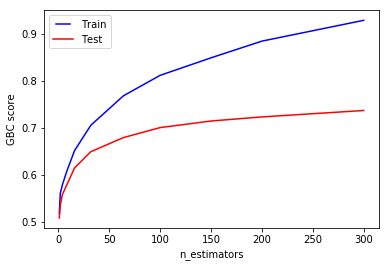

In [56]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('GBC score')
plt.xlabel('n_estimators')
plt.show()

In [57]:
n_estimators = [250, 300, 350, 400]

train_results = []
test_results = []

for estimator in n_estimators:
    gbc = GradientBoostingClassifier(n_estimators=estimator)
    gbc.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(gbc.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(gbc.score(X_test_scaled_idf, encoded_y_test_idf))

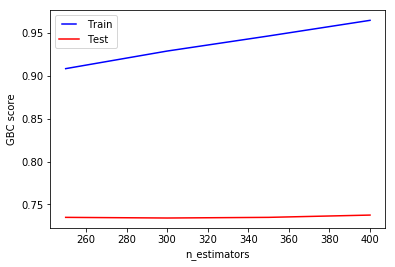

In [58]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('GBC score')
plt.xlabel('n_estimators')
plt.show()

In [ ]:
# Best: 

## GBC Max_Depth (TF-IDF Vectorizer)

In [59]:
max_depths = list(np.linspace(1, 90, 90, endpoint=True))

In [61]:
train_results = []
test_results = []
for max_depth in max_depths:
    gbc = GradientBoostingClassifier(max_depth=max_depth)
    gbc.fit(X_train_scaled_idf, encoded_y_train_idf)

    train_results.append(gbc.score(X_train_scaled_idf, encoded_y_train_idf))
    test_results.append(gbc.score(X_test_scaled_idf, encoded_y_test_idf))

KeyboardInterrupt: 

In [ ]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('RF score')
plt.xlabel('max_depths')
plt.show()